In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import glob
import numpy
from scipy import ndimage, signal
import matplotlib
matplotlib.use('PDF')
from galpy.util import bovy_conversion, bovy_plot
import gd1_util
from gd1_util import R0, V0
import bispectrum
import seaborn as sns
from matplotlib import cm, pyplot
from matplotlib.ticker import FuncFormatter, NullFormatter
%pylab inline
scaling= 'spectrum'
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Analysis of simulations with stream peppering for a GD-1 like stream

In [3]:
sdf_smooth= gd1_util.setup_gd1model()
print "Stream length in arc degree and physical kpc", sdf_smooth.length(ang=True), sdf_smooth.length(phys=True)

Stream length in arc degree and physical kpc 93.2298647352 12.3709203242


In [4]:
def median_csd(filename,filename2=None,scatter=False):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    if filename2 is None:
        data2= data1
    else:
        data2= numpy.genfromtxt(filename2,delimiter=',',max_rows=5002)
        # Search for batches
        batchfilenames= glob.glob(filename2.replace('.dat','.*.dat'))
        for bfilename in batchfilenames:
            try:
                datab= numpy.genfromtxt(bfilename,delimiter=',')
            except: continue
            data2= numpy.vstack((data2,datab[2:]))
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    px= signal.csd(data1[1],data2[1],fs=1./(apars[1]-apars[0]),scaling=scaling,nperseg=len(apars))[0]
    ppy= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        if numpy.any(data1 != data2):
            ppy[ii]= numpy.absolute(signal.csd(data1[2+ii]/data1[1],data2[2+ii]/data2[1],
                                               fs=1./(apars[1]-apars[0]),scaling=scaling,
                                               nperseg=len(apars))[1])
        else:
            ppy[ii]= signal.csd(data1[2+ii]/data1[1],data1[2+ii]/data1[1],
                                fs=1./(apars[1]-apars[0]),scaling=scaling,
                                nperseg=len(apars))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (180./px/numpy.pi,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(apars[-1]-apars[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(apars[-1]-apars[0]))
        ppy.sort(axis=0)
        return (180./px/numpy.pi,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(apars[-1]-apars[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(apars[-1]-apars[0])))

In [5]:
def plot_all(filename,color=sns.color_palette()[0],zorder=1,ls='-',
            fill=False,fill_color='0.65',fill_zorder=0,
            scale=1.):
    subplot(1,3,1)
    px, py= median_csd(filename)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        plotx, dum, low, high= median_csd(filename,scatter=True)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py= median_csd(filename.replace('dens','omega'))
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        plotx, dum, low, high= median_csd(filename.replace('dens','omega'),scatter=True)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py= median_csd(filename,filename.replace('dens','omega'))
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        plotx, dum, low, high= median_csd(filename,filename.replace('dens','omega'),scatter=True)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(0.0001,1.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{\Omega\Omega}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(0.0001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{|\delta\Omega|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(0.0001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar(vmin,vmax,clabel,save_figures=False,fmt=r'$%.1f$'):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=fmt)
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## Single times

In [6]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_onetime')

Spaced 1 Gyr apart

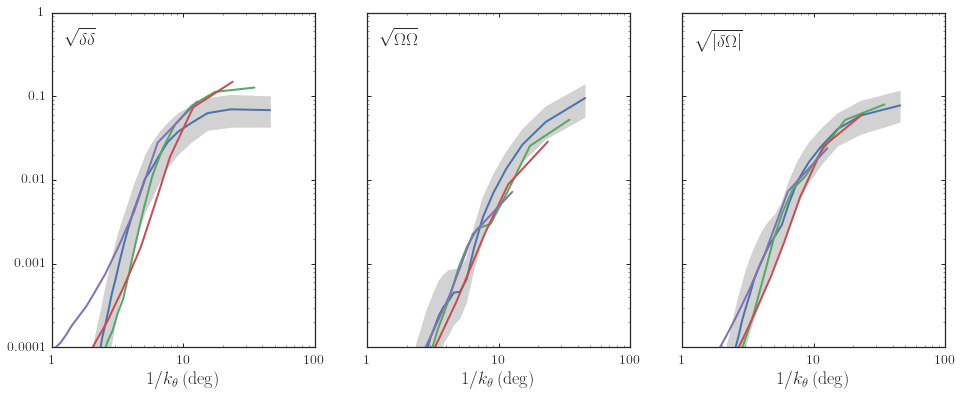

In [7]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1.0_6.5_dens.dat'),
         color=sns.color_palette()[0],zorder=6,fill=True)
plot_all(os.path.join(basefilename,'gd1_t2.0_6.5_dens.dat'),
         color=sns.color_palette()[1],zorder=6)
plot_all(os.path.join(basefilename,'gd1_t3.0_6.5_dens.dat'),
         color=sns.color_palette()[2],zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4.0_6.5_dens.dat'),
         color=sns.color_palette()[3],zorder=6)
set_ranges_and_labels()

Impacts near pericenter, near apocenter, and in between [radial period is $\approx400$ Myr]:

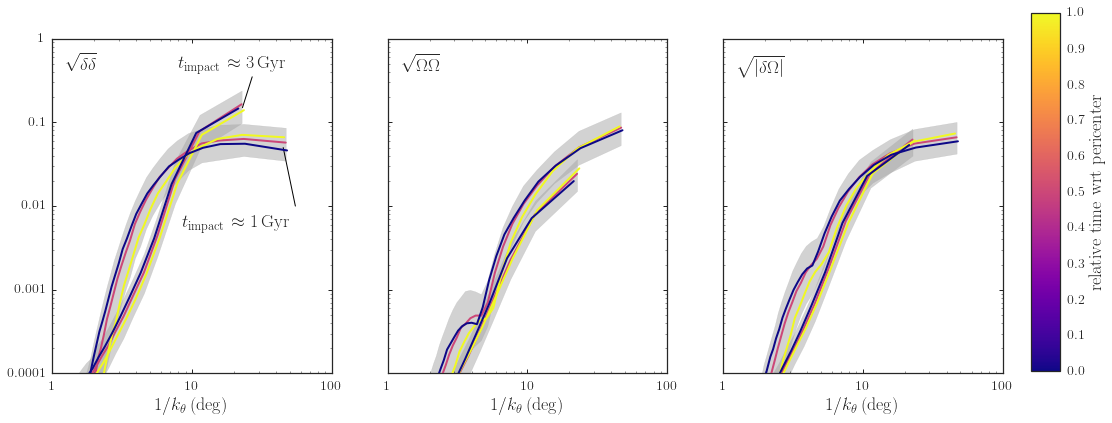

In [8]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
cmap= cm.plasma
plot_all(os.path.join(basefilename,'gd1_t0.81peri_6.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t3.21peri_6.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t1.01apo_6.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t3.01apo_6.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t0.9between_6.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t3.1between_6.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
set_ranges_and_labels()
# Annotate
subplot(1,3,1)
plot([23.,27],[0.15,0.35],'k-',lw=1.)
bovy_plot.bovy_text(8.,0.4,r'$t_{\mathrm{impact}} \approx 3\,\mathrm{Gyr}$',size=18.)
plot([45.,55.],[0.05,0.01],'k-',lw=1.)
bovy_plot.bovy_text(8.5,0.005,r'$t_{\mathrm{impact}} \approx 1\,\mathrm{Gyr}$',size=18.)
# Add colorbar
add_colorbar(0,1,r'$\mathrm{relative\ time\ wrt\ pericenter}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_periapobetween.pdf'))

Same for $M=10^{5.5}\,M_\odot$:

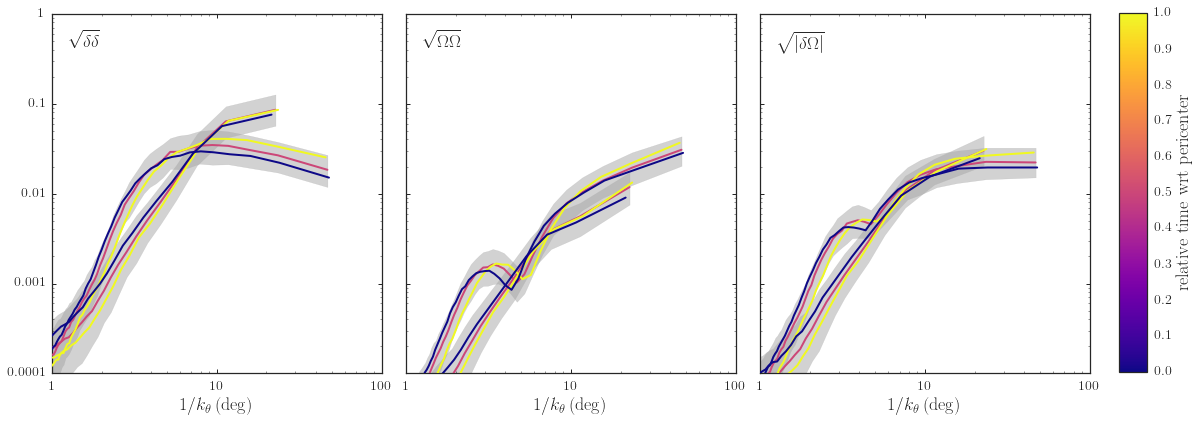

In [9]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
plot_all(os.path.join(basefilename,'gd1_t0.81peri_5.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t3.21peri_5.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t1.01apo_5.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t3.01apo_5.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t0.9between_5.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t3.1between_5.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
# Add colorbar
add_colorbar(0,1,r'$\mathrm{relative\ time\ wrt\ pericenter}$')

## Multiple times

How finely do we have to sample the impact-time grid to get statistically similar results? For $M=10^{6.5}\,M_\odot$:

In [10]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_multtime')

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



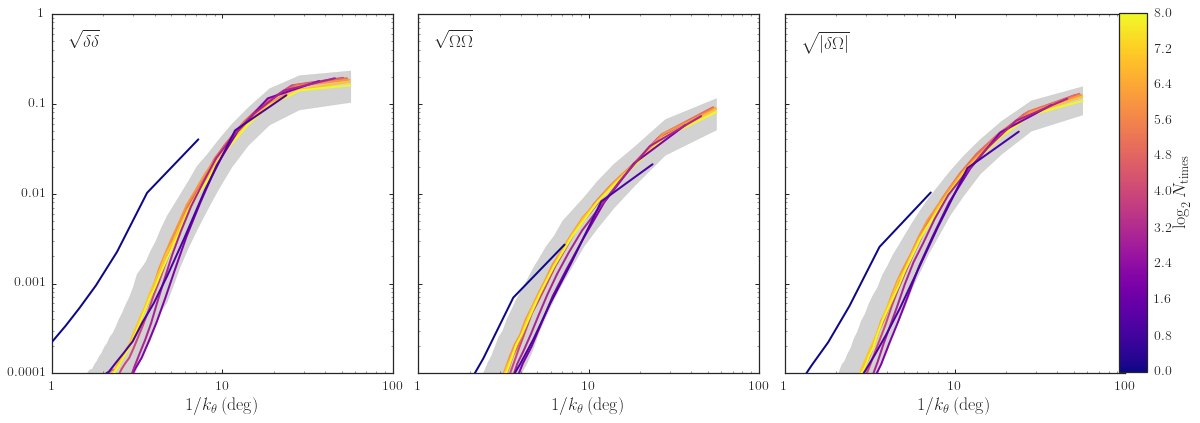

In [11]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(0,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t2sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(2,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t8sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t16sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(4,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t32sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t128sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(7,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(8,cmap,0.,8.),zorder=3,fill=True)
set_ranges_and_labels()
add_colorbar(0,8,r'$\log_2 N_{\mathrm{times}}$',save_figures=save_figures)
if not save_figures: tight_layout()
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_6p5timesampling.pdf'))

Same for $10^{5.5}\,M_\odot$:

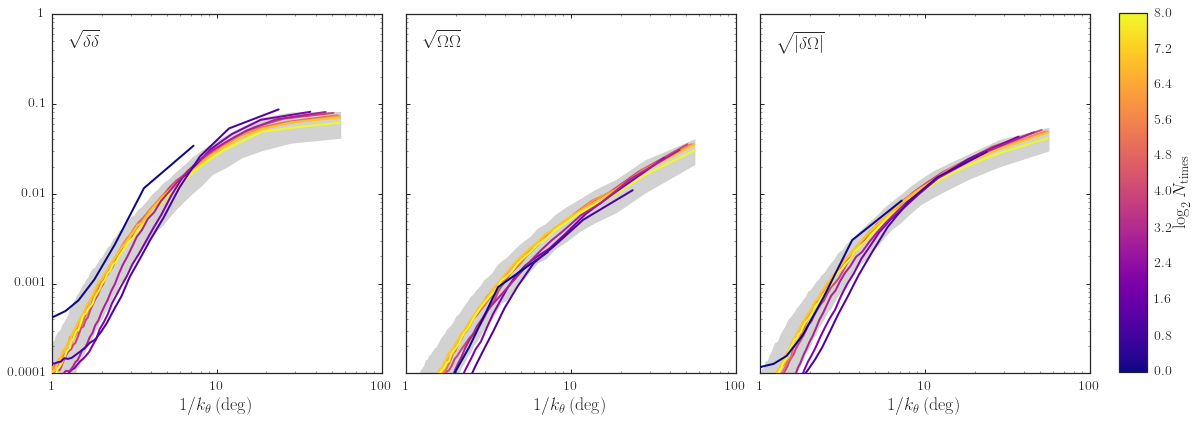

In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(0,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t2sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(2,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t8sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t16sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(4,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t32sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(6,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t128sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(7,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(8,cmap,0.,8.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,8,r'$\log_2 N_{\mathrm{times}}$')

Same for $10^{7.5}\,M_\odot$:

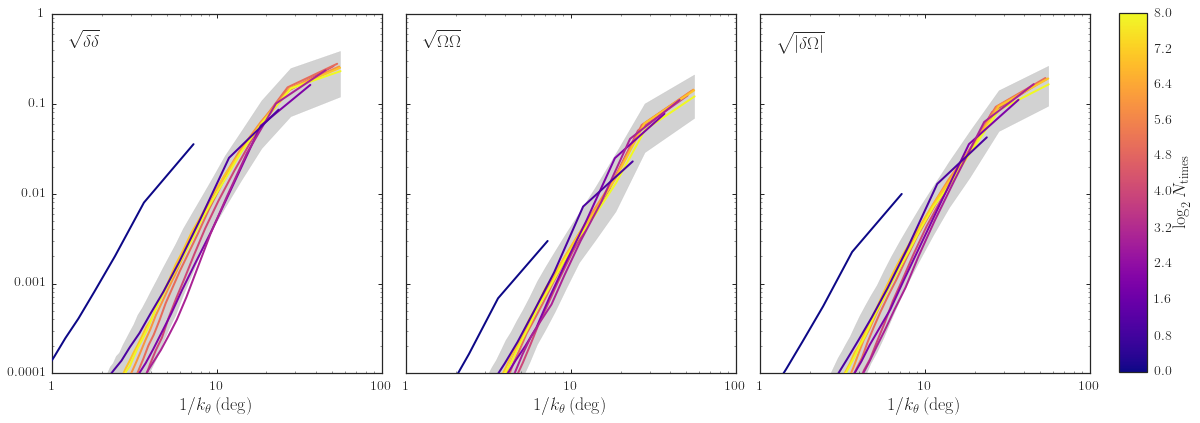

In [13]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(0,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t2sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(2,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t8sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t16sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(4,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t32sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(6,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t128sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(8,cmap,0.,8.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,8,r'$\log_2 N_{\mathrm{times}}$')

Comparing the effects of different mass ranges

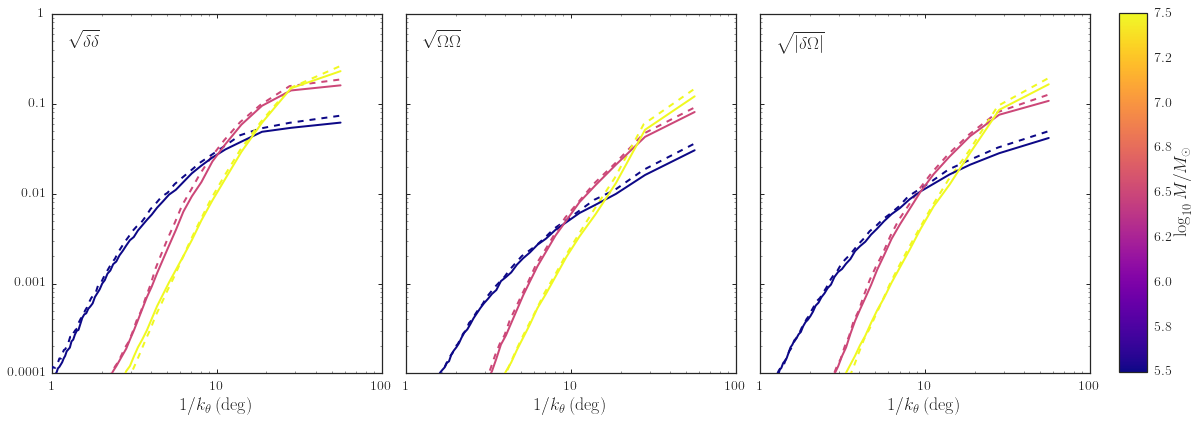

In [14]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5,ls='--')
set_ranges_and_labels()
tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$')

## Maximum impact parameter

How many times the scale radius do we need to consider for the impact parameter? We fix the number of potential impact times to 64 (which seems close to converged, see above). For $10^{6.5}\,M_\odot$:

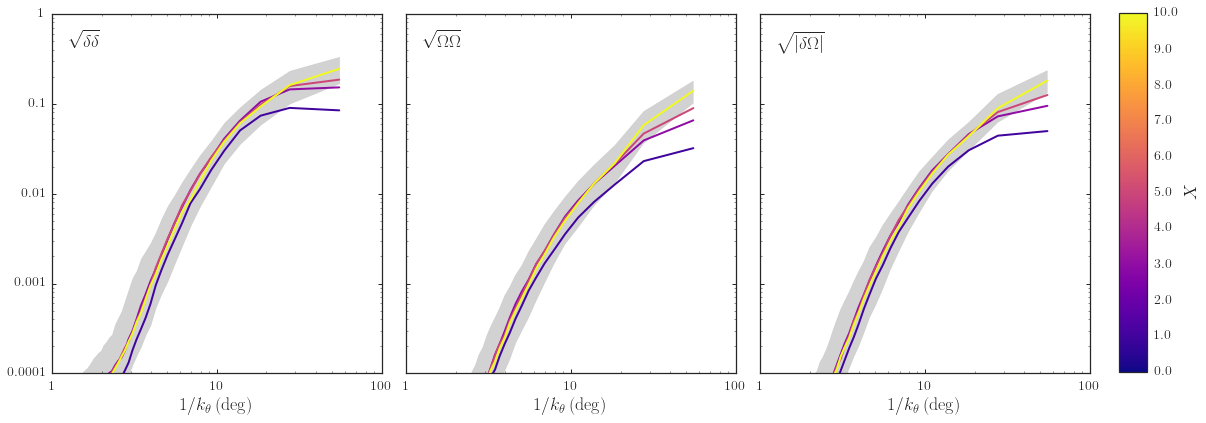

In [15]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X3_6.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X1_6.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(10.,cmap,0.,10.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,10,r'$X$')

Same for $10^{5.5}\,M_\odot$:

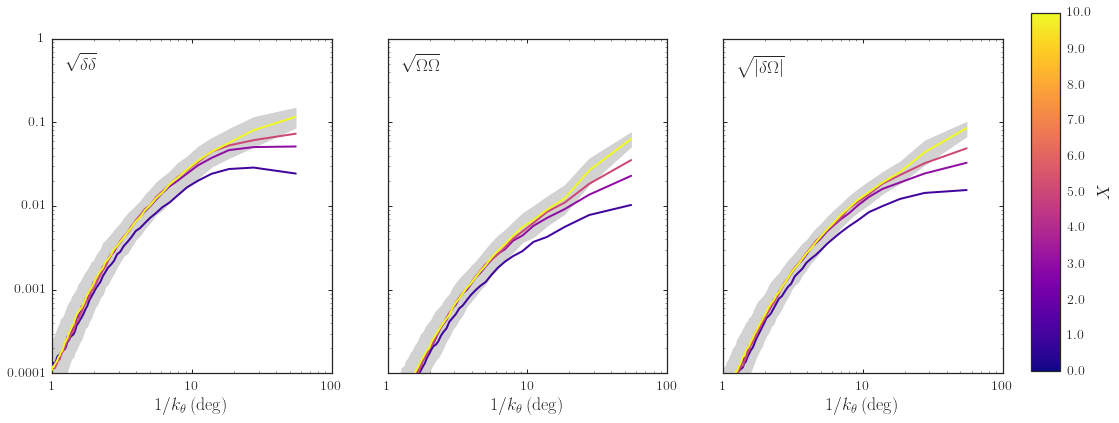

In [16]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X3_5.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X1_5.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_5.5_dens.dat'),
         color=color_from_colormap(10.,cmap,0.,10.),zorder=3,fill=True)
set_ranges_and_labels()
add_colorbar(0,10,r'$X$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_5p5bmax.pdf'))

Same for $10^{7.5}\,M_\odot$:

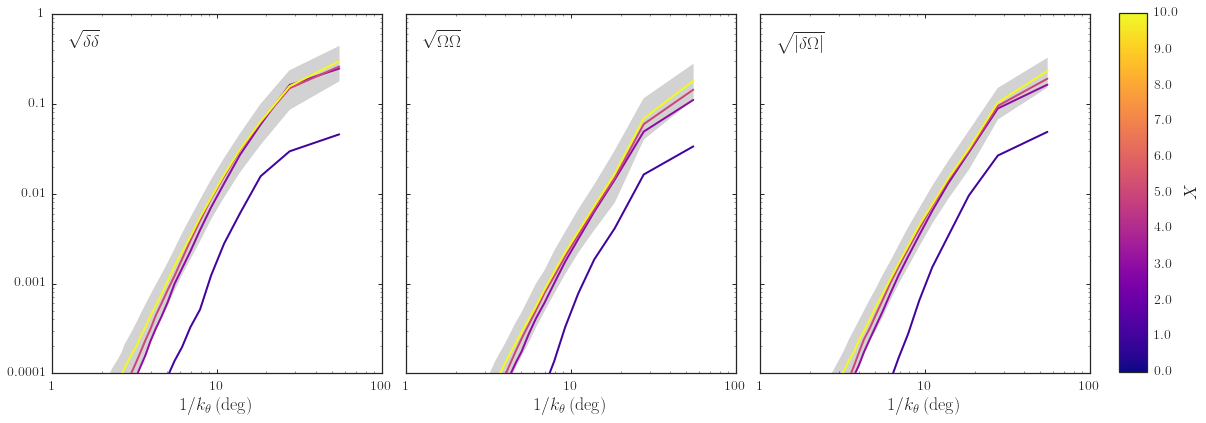

In [17]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X3_7.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X1_7.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(10.,cmap,0.,10.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,10,r'$X$')

Comparing the effects of different mass ranges

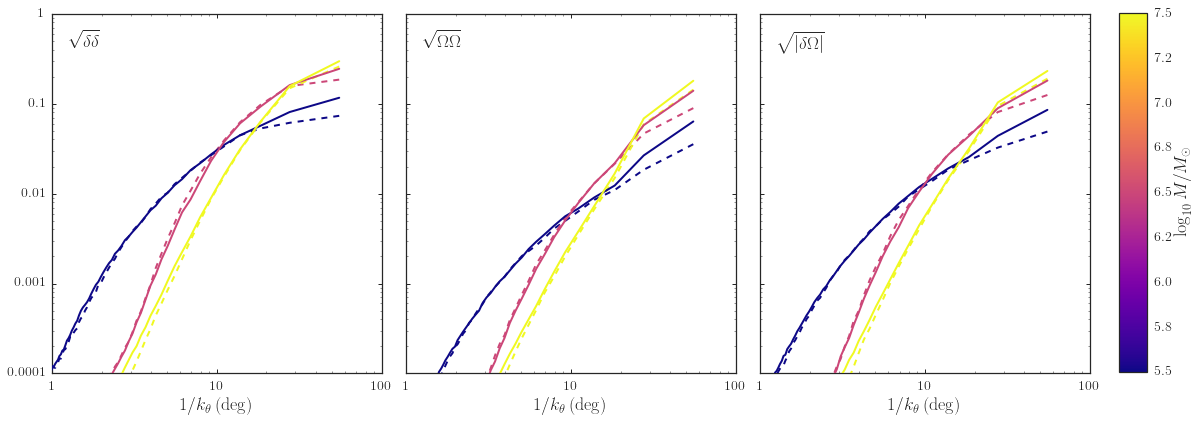

In [18]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5,ls='--')
set_ranges_and_labels()
tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$')

## How far along the stream do we have to allow impacts?

We consider impacts out to ``length_factor`` times the length of the stream. What is a good value of ``length_factor``?

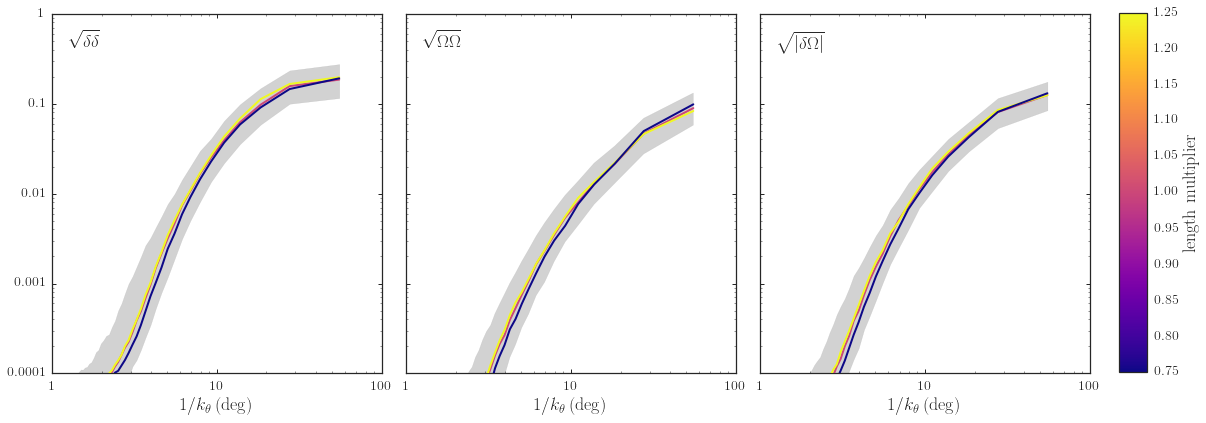

In [19]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.75,1.25),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf1p25_6.5_dens.dat'),
         color=color_from_colormap(1.25,cmap,0.75,1.25),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf0p75_6.5_dens.dat'),
         color=color_from_colormap(0.75,cmap,0.75,1.25),zorder=4)
set_ranges_and_labels()
tight_layout()
add_colorbar(0.75,1.25,r'$\mathrm{length\ multiplier}$',fmt=r'$%.2f$')

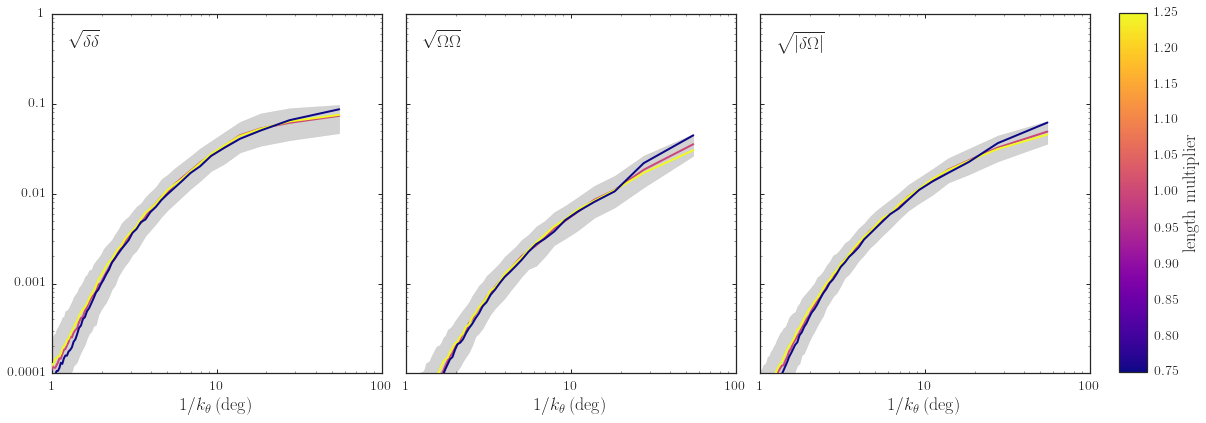

In [20]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.75,1.25),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf1p25_5.5_dens.dat'),
         color=color_from_colormap(1.25,cmap,0.75,1.25),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf0p75_5.5_dens.dat'),
         color=color_from_colormap(0.75,cmap,0.75,1.25),zorder=4)
set_ranges_and_labels()
tight_layout()
add_colorbar(0.75,1.25,r'$\mathrm{length\ multiplier}$',fmt=r'$%.2f$')

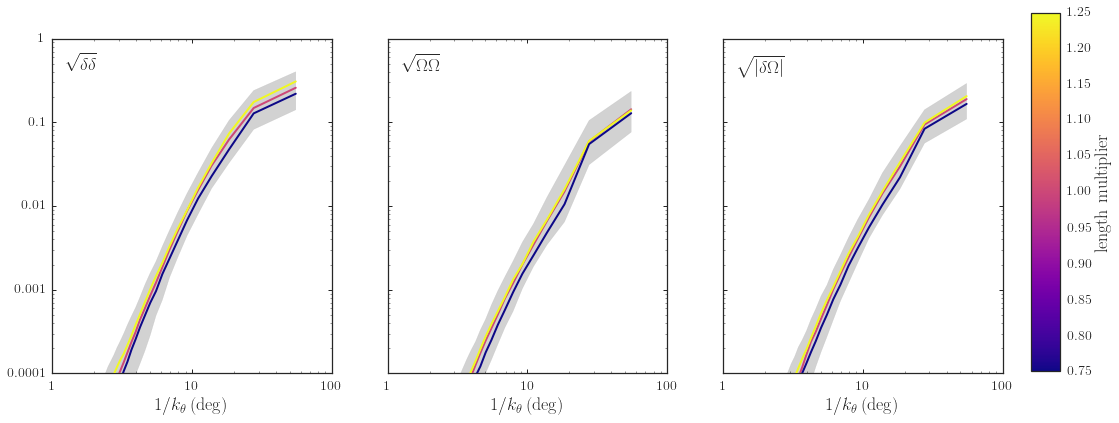

In [21]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.75,1.25),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf1p25_7.5_dens.dat'),
         color=color_from_colormap(1.25,cmap,0.75,1.25),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf0p75_7.5_dens.dat'),
         color=color_from_colormap(0.75,cmap,0.75,1.25),zorder=4)
set_ranges_and_labels()
add_colorbar(0.75,1.25,r'$\mathrm{length\ multiplier}$',fmt=r'$%.2f$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_7p5lenfac.pdf'))

## bmax, time sampling, and length-factor approximations on the same figure

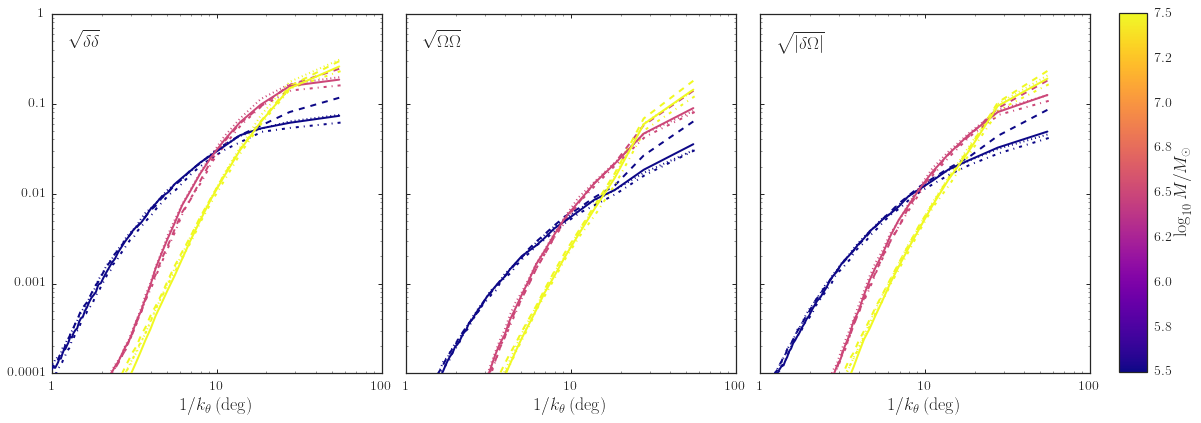

In [22]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=6,ls='-.')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf1p25_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=4,ls=':')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=6,ls='-.')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf1p25_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=4,ls=':')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=6,ls='-.')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
plot_all(os.path.join(basefilename,'gd1_t64sampling_lf1p25_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=4,ls=':')
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_bmaxtimesampling.pdf'))

## Hernquist vs. Plummer

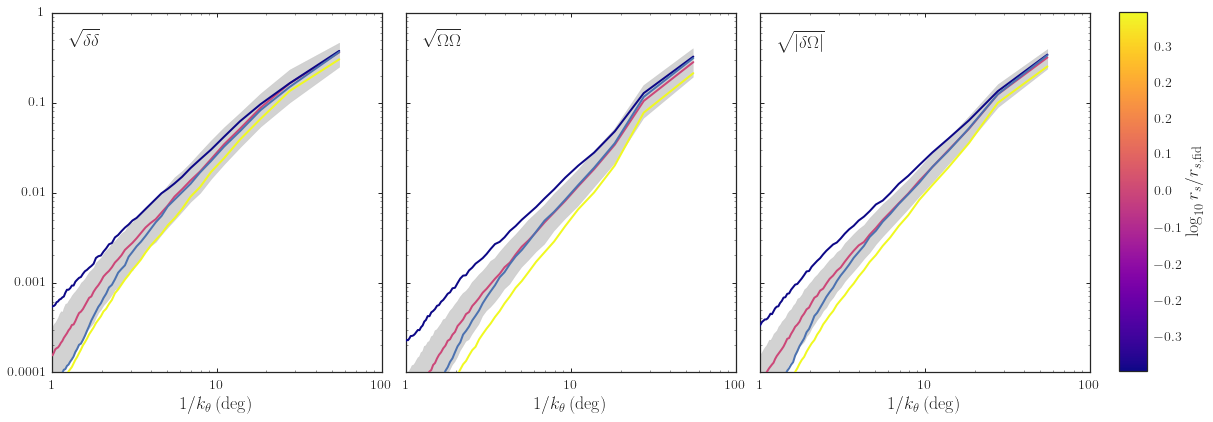

In [23]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(0.,cmap,numpy.log10(0.4),numpy.log10(2.5)),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X12p5_rsfacp4_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(0.4),cmap,numpy.log10(0.4),numpy.log10(2.5)),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X2_rsfac2p5_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(2.5),cmap,numpy.log10(0.4),numpy.log10(2.5)),zorder=10)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X3p24_plum_5-9_dens.dat'),
         color=sns.color_palette()[0],zorder=11)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(numpy.log10(0.4),numpy.log10(2.5),r'$\log_{10} r_s/r_{s,\mathrm{fid}}$',save_figures=save_figures)
if save_figures:
    subplot(1,3,1)
    plot([7.,12.],[0.000225,0.000225],color=sns.color_palette()[0],lw=2.)
    bovy_plot.bovy_text(15.,0.000175,r'$\mathrm{Plummer}$',size=18.)
    plot([7.,12.],[0.0005,0.00050625],color=color_from_colormap(numpy.log10(0.4),cmap,numpy.log10(0.4),numpy.log10(2.5)),
         lw=2.)
    plot([7.,12.],[0.00045,0.00045],color=color_from_colormap(numpy.log10(1.),cmap,numpy.log10(0.4),numpy.log10(2.5)),
         lw=2.)
    plot([7.,12.],[0.0004,0.0004],color=color_from_colormap(numpy.log10(2.5),cmap,numpy.log10(0.4),numpy.log10(2.5)),
         lw=2.)
    bovy_plot.bovy_text(15.,0.000375,r'$\mathrm{Hernquist}$',size=18.)
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_rsplummer.pdf'))

## Rate = multiple of CDM prediction

Can we just scale the CDM prediction?

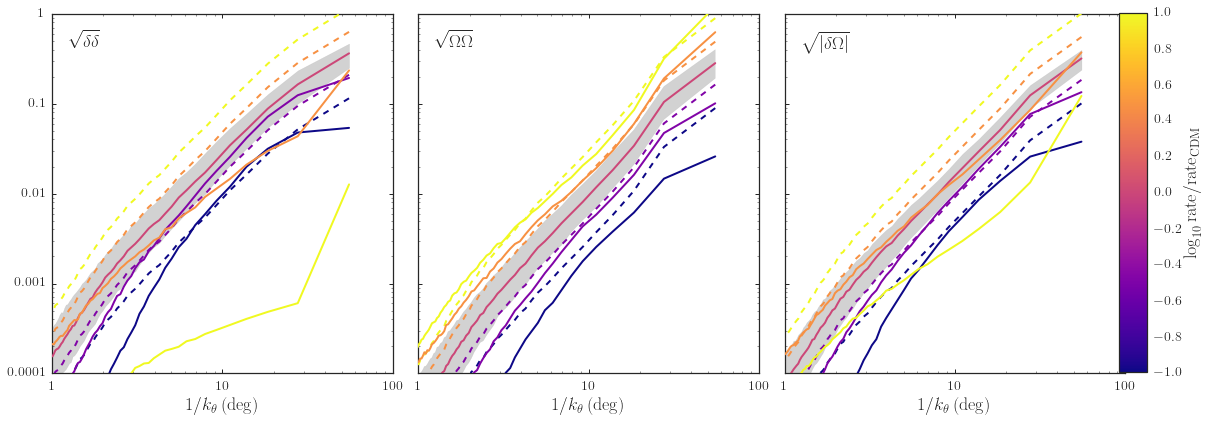

In [24]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp33_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.333333),ls='--',
         color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdm3_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(3.),ls='--',
         color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp1_5-9_dens.dat'),
         color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.1),ls='--',
         color=color_from_colormap(-1.,cmap,-1.,1.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdm10_5-9_dens.dat'),
         color=color_from_colormap(1.,cmap,-1.,1.),zorder=10)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(10.),ls='--',
         color=color_from_colormap(1.,cmap,-1.,1.),zorder=8)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_multcdm.pdf'))
else:
    tight_layout()

## Dependence on age

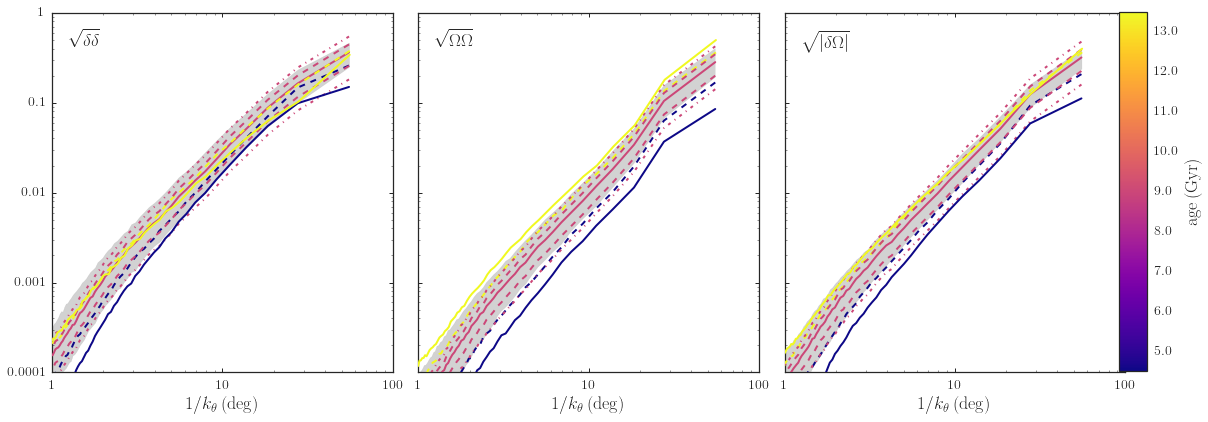

In [25]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_age4p5_5-9_dens.dat'),
         color=color_from_colormap(4.5,cmap,4.5,13.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_age4p5_cdm2_5-9_dens.dat'),ls='--',
         color=color_from_colormap(4.5,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.5),ls='--',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=0.5,ls='-.',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t96sampling_X5_age13p5_5-9_dens.dat'),
         color=color_from_colormap(13.5,cmap,4.5,13.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t96sampling_X5_age13p5_cdmp66_5-9_dens.dat'),ls='--',
         color=color_from_colormap(13.5,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(1.5),ls='--',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=1.5,ls='-.',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(4.5,13.5,r'$\mathrm{age}\,(\mathrm{Gyr})$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_age.pdf'))
else:
    tight_layout()

## CDM spectrum with cut-off

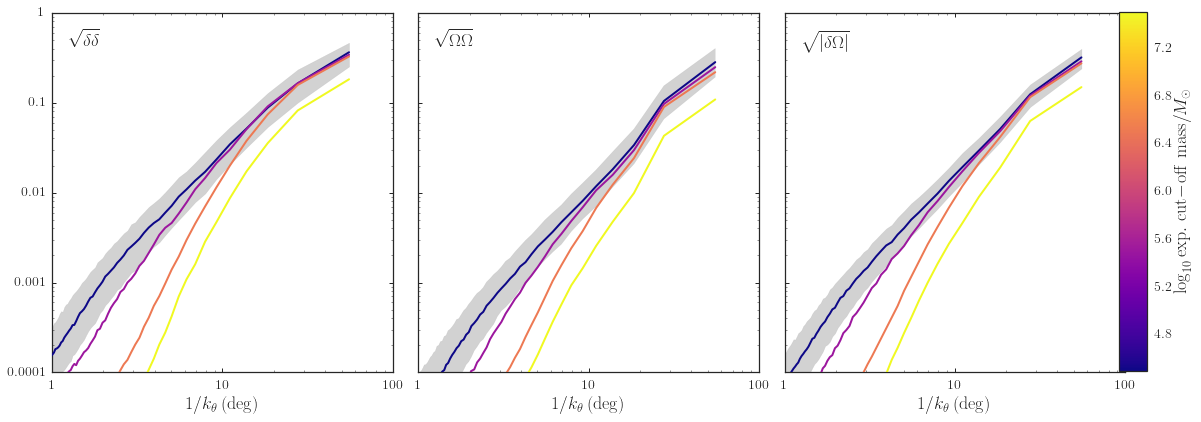

In [46]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(4.5,cmap,4.5,7.5),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cutoff5p5_5-9_dens.dat'),
         color=color_from_colormap(5.5,cmap,4.5,7.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cutoff6p5_5-9_dens.dat'),
         color=color_from_colormap(6.5,cmap,4.5,7.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cutoff7p5_5-9_dens.dat'),
         color=color_from_colormap(7.5,cmap,4.5,7.5),zorder=9)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(4.5,7.5,r'$\log_{10} \mathrm{exp.\ cut\!-\!off\ mass} / M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_cutoff.pdf'))
else:
    tight_layout()

## Dependence on the velocity dispersion of the DM subhalos

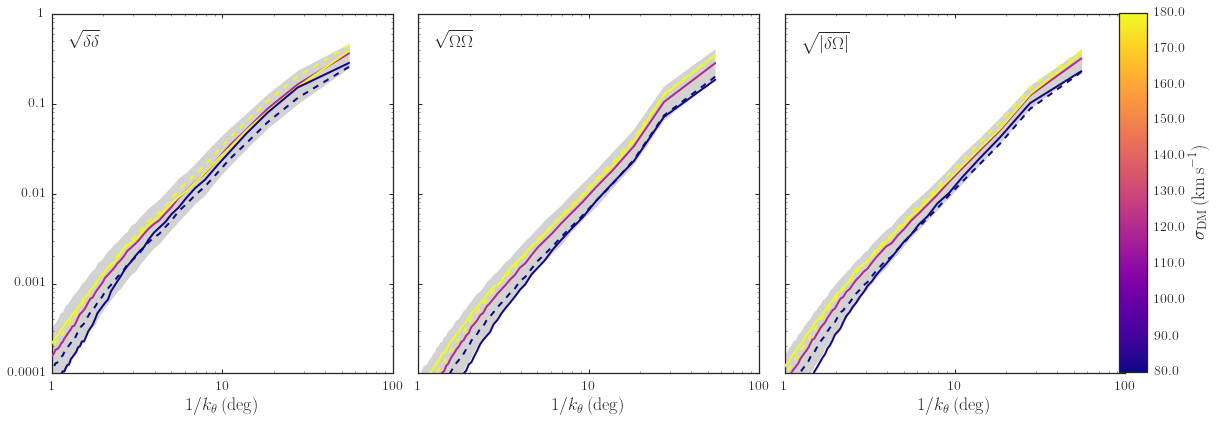

In [50]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(120.,cmap,80.,180.),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_sigma180_5-9_dens.dat'),
         color=color_from_colormap(180.,cmap,80.,180.),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(1.5),ls='--',
         color=color_from_colormap(180.,cmap,80.,180.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_sigma80_5-9_dens.dat'),
         color=color_from_colormap(80.,cmap,80.,180.),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.5),ls='--',
         color=color_from_colormap(80.,cmap,80.,180.),zorder=8)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(80,180,r'$\sigma_{\mathrm{DM}}\,(\mathrm{km\,s}^{-1})$',save_figures=save_figures)
if not save_figures: tight_layout()
#if save_figures:
#    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_cutoff.pdf'))

## The bispectrum

In [27]:
def median_bispectrum(filename,ind,scatter=False,limitnsim=None):
    # Compute the median bispectrum
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    apars= data1[0]
    tdata= (data1[2:]/data1[1]).T
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata[:,0],tdata[:,0])).T,nfft=len(tdata),wind=7,nsamp=1,overlap=0)
    if not limitnsim is None: nsim= limitnsim
    ppyr= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    for ii in range(nsim):
        Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata[:,ii],tdata[:,ii])).T,nfft=len(tdata),wind=7,nsamp=1,overlap=0)
        ppyr[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
        ppyi[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
    if not scatter:
        return (180./numpy.pi/px[len(Bspec)//2:]*(apars[1]-apars[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0))
    else:
        ppyr.sort(axis=0)
        ppyi.sort(axis=0)
        return (180./numpy.pi/px[len(Bspec)//2:]*(apars[1]-apars[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0),
                ppyr[int(numpy.round(0.25*nsim))],
                ppyr[int(numpy.round(0.75*nsim))],
                ppyi[int(numpy.round(0.25*nsim))],
                ppyi[int(numpy.round(0.75*nsim))])

In [28]:
def plot_all_bispectrum(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        scale=1.,ind=5,nsim=None):
    # ind = 5 corresponds to 11.069544601927502 degree in parallel angle
    subplot(1,4,1)
    px, pyr, pyi= median_bispectrum(filename,ind,limitnsim=nsim)
    loglog(px,scale*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    subplot(1,4,2)
    loglog(px,scale*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        subplot(1,4,1)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename,ind,scatter=True,
                                                                     limitnsim=nsim)
        fill_between(plotx,scale*lowr,scale*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,2)
        fill_between(plotx,scale*lowi,scale*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,4,3)
    px, pyr, pyi= median_bispectrum(filename.replace('dens','omega'),ind,
                                    limitnsim=nsim)
    loglog(px,scale*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    subplot(1,4,4)
    loglog(px,scale*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        subplot(1,4,3)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename.replace('dens','omega'),
                                                                     ind,scatter=True,limitnsim=nsim)
        fill_between(plotx,scale*lowr,scale*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,4)
        fill_between(plotx,scale*lowi,scale*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_bispectrum(low=0.00001,high=20.):
    subplot(1,4,1)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,4,2)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,3)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(\Omega\Omega\Omega)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,4)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(\Omega\Omega\Omega)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{\theta}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def add_colorbar_bispectrum(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.925)
        cbar_ax = fig.add_axes([0.99, 0.13, 0.025, 0.845])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

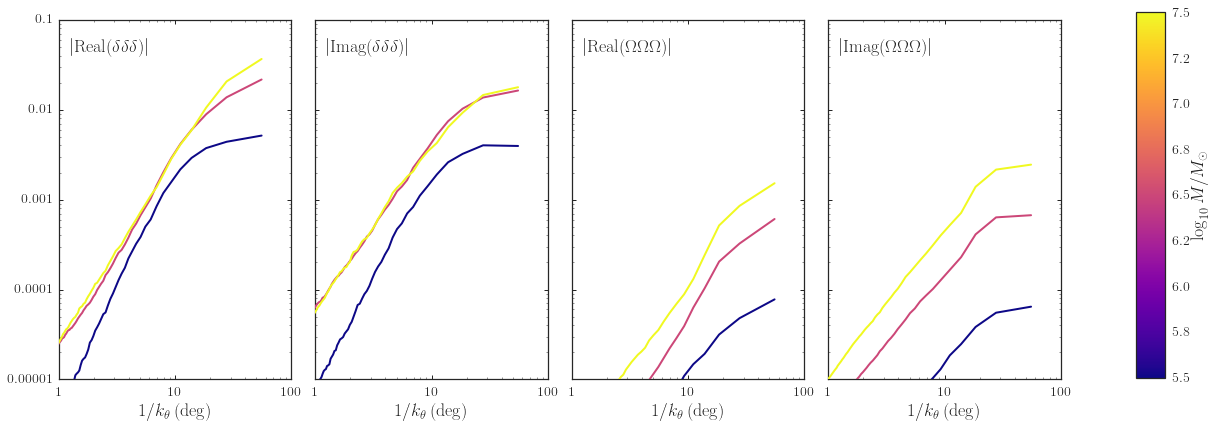

In [29]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
                    color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,nsim=None)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
                    color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7,nsim=None)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
                    color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7,nsim=None)
set_ranges_and_labels_bispectrum(high=.1)
if not save_figures: tight_layout()
add_colorbar_bispectrum(5.5,7.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'gd1like_bispectrum_massranges.pdf'))

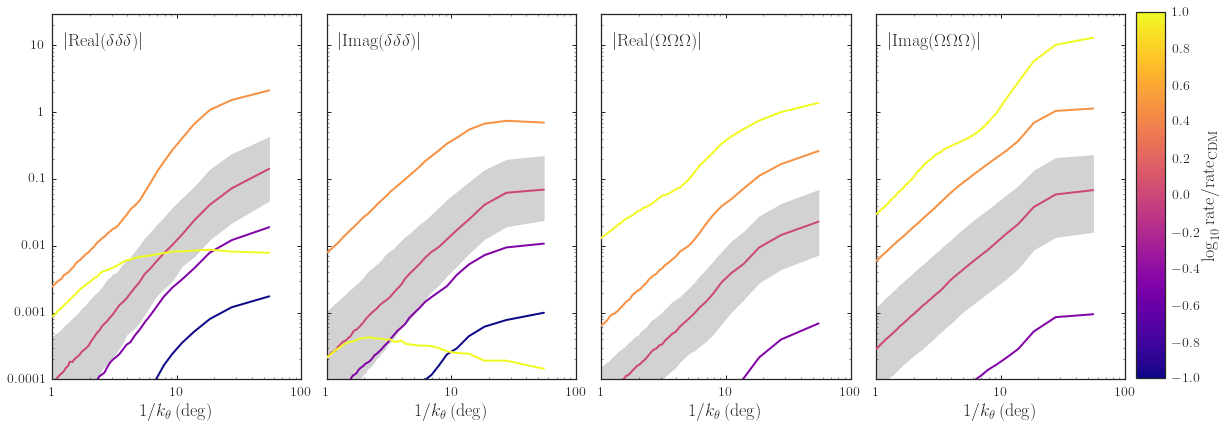

In [30]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
                    color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True,nsim=None)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp33_5-9_dens.dat'),
                    color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,nsim=None)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdm3_5-9_dens.dat'),
                    color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,nsim=None)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp1_5-9_dens.dat'),
                    color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,nsim=None)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdm10_5-9_dens.dat'),
                    color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,nsim=None)
set_ranges_and_labels_bispectrum(low=0.0001,high=30.)
if not save_figures: tight_layout()
add_colorbar_bispectrum(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'gd1like_bispectrum_rate.pdf'))
else:
    tight_layout()

# Some simulations of Pal 5 in frequency-angle space

IOError: /Users/bovy/data/streamgap-pepper/pal5_multtime/pal5_t64sampling_X5_5.5_dens.dat not found.

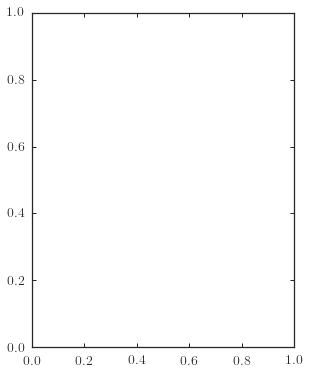

In [31]:
basefilename_pal5= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,8.5),zorder=7)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,8.5),zorder=7)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,8.5),zorder=7,ls='--')
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,8.5),zorder=7)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,8.5),zorder=7,ls='--')
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X20_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,8.5),zorder=7,ls='-.')
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_8.5_dens.dat'),
         color=color_from_colormap(8.5,cmap,5.5,8.5),zorder=7)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X10_8.5_dens.dat'),
         color=color_from_colormap(8.5,cmap,5.5,8.5),zorder=7,ls='--')
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X20_8.5_dens.dat'),
         color=color_from_colormap(8.5,cmap,5.5,8.5),zorder=7,ls='-.')
set_ranges_and_labels()
tight_layout()
add_colorbar(5.5,8.5,r'$\log_{10} M/M_\odot$',save_figures=False)

In [ ]:
basefilename_pal5= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','pal5_multtime')
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
figsize(16,6)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_cdmp33_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_cdm3_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_cdmp1_5-9_dens.dat'),
         color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9)
plot_all(os.path.join(basefilename_pal5,'pal5_t64sampling_X5_cdm10_5-9_dens.dat'),
         color=color_from_colormap(1.,cmap,-1.,1.),zorder=10)
set_ranges_and_labels()
tight_layout()
add_colorbar(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=False)